# Workflows and Tasks

This example notebook shows how to build a very generic workflow with many inputs and dependecies. In order to keep the example short and easy to follow the workflow performs basic algebraic operation instead of executing an Earth observation processing chain. 

The algebraic operation is: $A*B + C + 2$

In [1]:
from eolearn.core import EOTask, EOWorkflow, Dependency

## Step 1: Define/Implement EOTasks

Typically this step is not necessary since the `eolearn` library already provides a set of Earth observation tasks. But for our generic example we need to implement them. As you can see, the implementation of `EOTask` is very easy and introduces almost no overhead.

### Input task

The purpose of input task is to create input dataobjects on which the subsequent tasks will be executed. In our simple example the dataobject is a *number* so we simply need to implement a task that returns a number. The value of this number can be specified by a user. 

In Earth observation application the tasks operate with `EOPatch`es.

In [2]:
class InputNumber(EOTask):
    """
    The task returns the user specified input number. 
    """
    def execute(self, *, input_number):
        """
        Return the input_number.
        """
        return input_number

### Add constant

In the above task the user can specify a new input number each time the workflow (and all the tasks in it) are executed. In some cases the input is the same (i.e. constant) for all executions. In such cases, task specific parameter can be used.

In [3]:
class AddConstant(EOTask):
    """
    The task adds a task-specific constant value to the input dataobject and returns the sum.
    """
    def __init__(self, constant):
        self.constant = constant
        
    def execute(self, number):
        """
        Add constant to input and return the sum.
        """
        return number+self.constant

### Multiply two numbers

The tasks can have more than one input, like in the case of the multiplication task.

In [4]:
class Multiply(EOTask):
    def execute(self, x, y):
        """
        Return the product of two inputs.
        """
        return x * y

### Sum numbers

The tasks can have even more inputs.

In [5]:
class Sum(EOTask):
    def execute(self, *numbers):
        """
        Return the sum of all inputs.
        """
        return sum(numbers)

## Step 2: Initialize tasks

The algebraic operation that we want to execute is $A*B + C + 2$. This operation has three inputs and performs three operations:
   * multiplies $A$ and $B$
   * adds 2 to $C$
   * and adds everything up
   
Each input and each operation require their own task instance.

In [6]:
in_a = InputNumber()
in_b = InputNumber()
in_c = InputNumber()
add_2 = AddConstant(2)
multi_ab= Multiply()
sum_all = Sum()

## Step 3: Define workflow 

Chain the tasks into a directed acyclic graph.

The input tasks have no inputs, since they don't depend on the result of any other task. The multiplication task ($A*B$) depends on the result of input tasks `in_a` ($A$) and `in_b` ($B$), and so on.

The `task_names` argument in the `EOWorkflow` initialisation is optional. It's added to make the graphs more human readable.

In [7]:
dag = EOWorkflow(dependencies=[
                    Dependency(transform=in_a, inputs=[]),
                    Dependency(transform=in_b, inputs=[]),
                    Dependency(transform=in_c, inputs=[]),
                    Dependency(transform=multi_ab, inputs=[in_a, in_b]),
                    Dependency(transform=add_2, inputs=[in_c]),
                    Dependency(transform=sum_all, inputs=[multi_ab, add_2])],
                 task_names={in_a:'A', in_b:'B', in_c:'C', 
                          multi_ab:'A*B', add_2:'C+2', sum_all:'Sum'}
                )

#### Lets look into execution order, dependencies, etc..

The graph is linearized and the execution of tasks is done one at the time. 

In [8]:
dag.ordered_dependencies

[A, C, B, C+2, A*B, Sum]

Show on how many inputs each task depends on:

In [9]:
dag.dag.get_indegrees()

defaultdict(int, {A*B: 2, C+2: 1, Sum: 2, A: 0, C: 0, B: 0})

Visualize the graph:

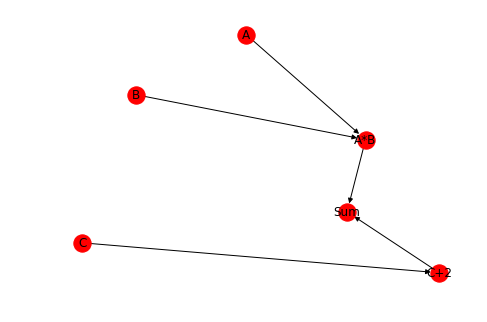

In [10]:
dag.dependency_graph('index.dot', view=True)

Better visualisation with `graphviz` (only works if you have it installed). Next cell will create an index.dot.png image.

In [11]:
!dot -O -Tpng index.dot 

## Step 4: Execute the workflow

In our example we have to provide the values of $A$, $B$, and $C$:

In [12]:
dag.execute({in_a:{'input_number':5},
             in_b:{'input_number':3},
             in_c:{'input_number':2}})

WorkflowResults(
  Dependency(Sum): 19
)

Execute the same workflow on a different input:

In [13]:
dag.execute({in_a:{'input_number':1},
             in_b:{'input_number':1},
             in_c:{'input_number':-3}})

WorkflowResults(
  Dependency(Sum): 0
)